## Preprocessing raw EEG data for deep learning models

+ Prepare EEG 
1. Subtract reference (mastoids)
2. Detrend 
3. Filter
4. Remove bad channels

+ Segment EEG into standard and deviant epochs (ERPs)
1. subtract baseline
2. Reject artefacts
3. Average (for each marker/subject/channel separately))

+ Calculate Mismatch response 
1. deviant - standard for a single subject, for example GiepST_
2. check differences between channels and subjects)


+ Extract features:
1. peak latency
2. peak amplitude
3. mean amplitude, ...

#### Questions about ePod dataset and preprocessing:

+ EXG1 and EXG2 (mastoids) seem much noisier than other channels. will these as reference be problematic?
+ How much noise can we expect?
+ Are there any preprocessing/artifect detection steps already performed?
+ How is the data created? (epod_raw[participant_index].info reveals Lowpass of 417.00 Hz) 
+ What do we want to save to the cloud? And do we want the same settings for our pre-processed data?
+ What is the best way to organise the data as input into DL? 

1. Raw --  Advantages: Perhaps no preprocessing if DL learns to ignore noisy data.  Disadvantages: Very large data structure, relatively few raw data files. 
2. Epochs -- Advantages:
3. Evoked (ERP) -- Disadvantage: Large noise signals can ruin the final averaged ERP
+ Bjorn organised data: 
1. Sample 30 EEG epochs from raw (many different combinations possible, so data is constantly different)
2. Average the epochs (into ERP), which reduces the noise


#### Import Packages 

In [1]:
import mne              # toolbox for analyzing and visualizing EEG data
import pandas as pd     # data analysis and manipulation
import numpy as np      # numerical computing (manipulating and performing operations on arrays of data)
import os               # using operating system dependent functionality (folders)
import glob             # functions for matching and finding pathnames using patterns
import copy             # Can Copy and Deepcopy files so original file is untouched
import sys              # system-specific information and resources
import matplotlib.pyplot as plt

main_path = os.path.dirname(os.path.dirname(os.getcwd()))
repo_path = os.path.join(main_path, 'ePodium')
data_path = os.path.join(main_path, 'researchdrive', 'ePodium (Projectfolder)')

eegyolk_path = os.path.join(repo_path, 'eegyolk')
sys.path.insert(0, eegyolk_path)
from eegyolk import initialization_functions as ifun
from eegyolk import epod_helper as epod
from eegyolk import display_helper as disp
from eegyolk import preprocessing_functions as prep

#### Load Data

In [2]:
folder_epod_dataset = os.path.join(data_path, "Dataset")
folder_epod_events = os.path.join(data_path, "events")

epod_raw, epod_filenames = ifun.load_dataset(folder_epod_dataset, preload=False)
epod_raw_preload, epod_filenames_preload = ifun.load_dataset(folder_epod_dataset, preload=True, max_files = 6)

events = ifun.load_events(folder_epod_events, epod_filenames)
events_12 = epod.group_events_12(events)

Extracting EDF parameters from c:\Floris\Python Folder\Thesis Code\researchdrive\ePodium (Projectfolder)\Dataset\103b.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4294655  =      0.000 ...  2097.000 secs...
6 EEG files loaded
196 Event Marker files loaded


#### Visualise ePOD dataset

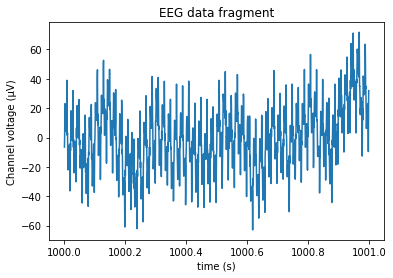

In [3]:
participant_index = 4
channel_index = 1
%matplotlib inline
disp.show_raw_fragment(epod_raw[participant_index], channel_index, duration = 1, start = 1000, average=True)

#### Interactive window
Interact with raw EEG data

Using matplotlib as 2D backend.
Opening raw-browser...


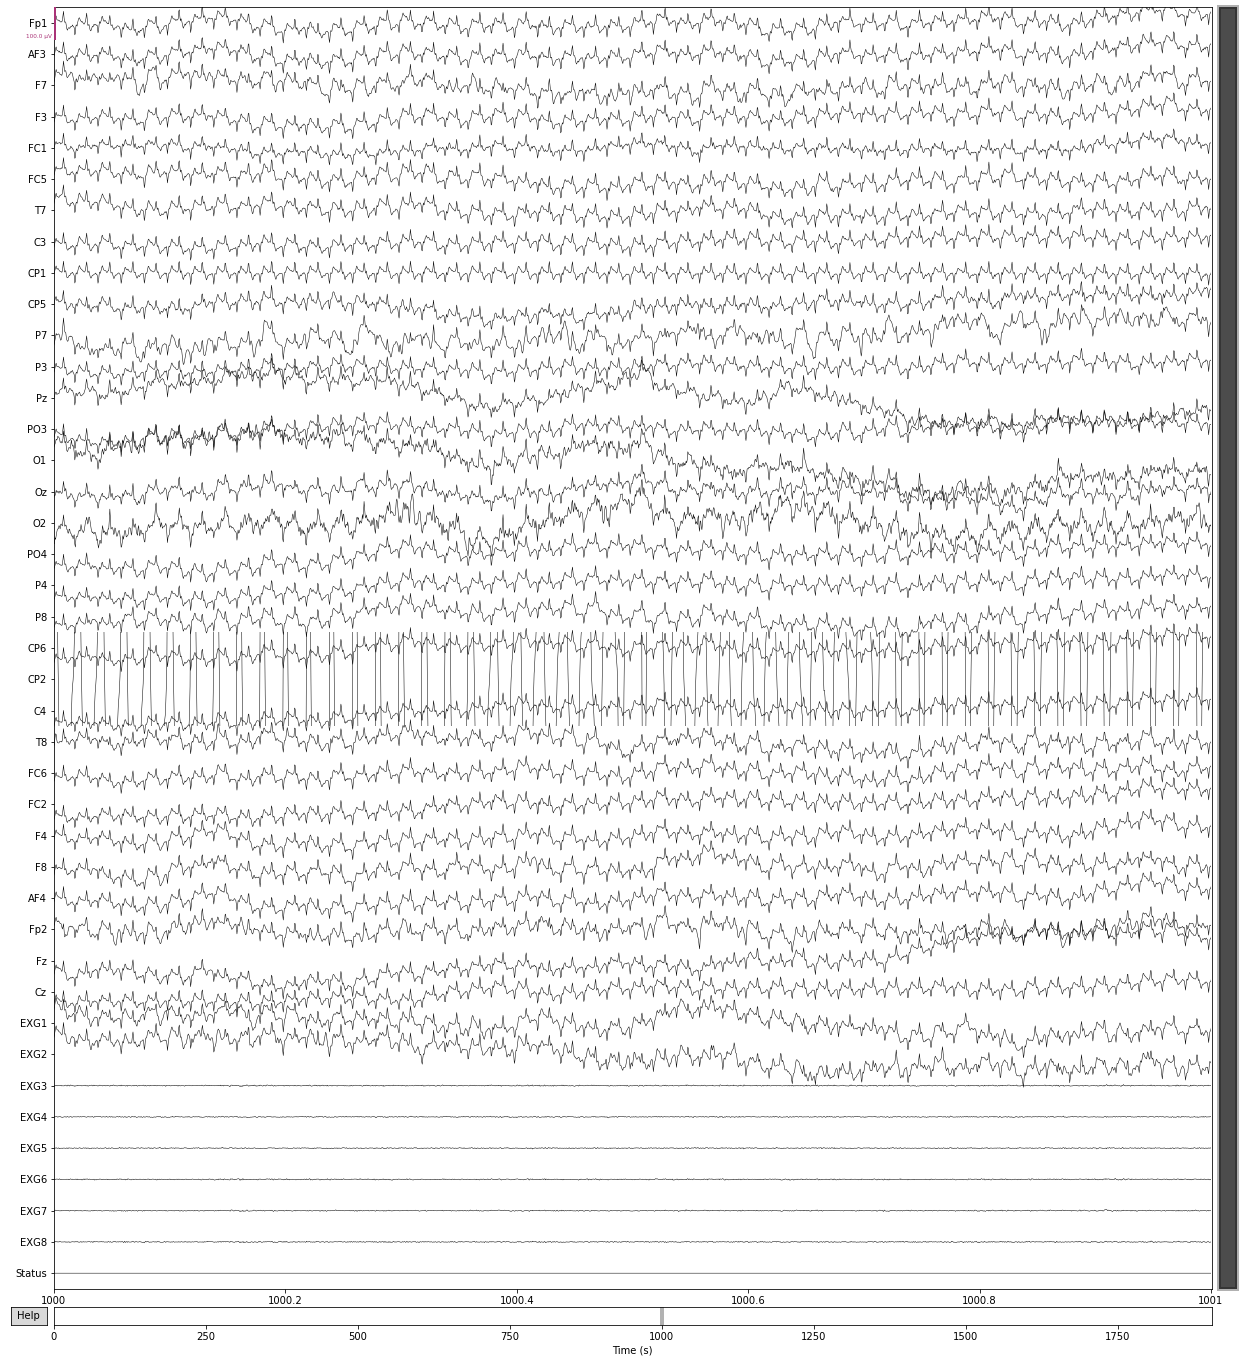

In [4]:
# %matplotlib qt / widget for external/internal interactive window (remove 'fig = ' if no figure shows) (try installing pip install PyQt5 if qt failed due to import binding)
# %matplotlib qt 
fig = mne.viz.plot_raw(epod_raw_preload[participant_index], events[participant_index], n_channels=50, scalings = 50e-6  ,duration = 1, start = 1000)

#### Prepare EEG 

+ Drop unused channels
+ Subtract reference (mastoids) 
+ Detrend 
+ Filter
+ Remove bad channels

epod_raw_preload is used, since some functionalities require preloaded data.


In [5]:
def preprocess_raw(raw):  
    ## Drop unused channels  
    drop_channels = ['EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status']
    try:
        raw.drop_channels(drop_channels)
    except: print("channels not found")

    ## Subtract reference
    mastoid_channels = ['EXG1', 'EXG2']
    raw = raw.set_eeg_reference(ref_channels=mastoid_channels)

    ## Detrend
    # scipy.signal.detrend

    ## Filter 
    # raw = raw.filter(0.5, 40, fir_design='firwin')

    return raw

epod_raw_filtered = []

for participant_index in range(len(epod_raw_preload)):
    print(f"preprocessing participant {participant_index}")

    epod_raw_filtered.append(preprocess_raw(epod_raw_preload[participant_index])) 

    # Remove bad channels


preprocessing participant 0
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
preprocessing participant 1
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
preprocessing participant 2
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
preprocessing participant 3
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
preprocessing participant 4
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
preprocessing participant 5
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


Opening raw-browser...


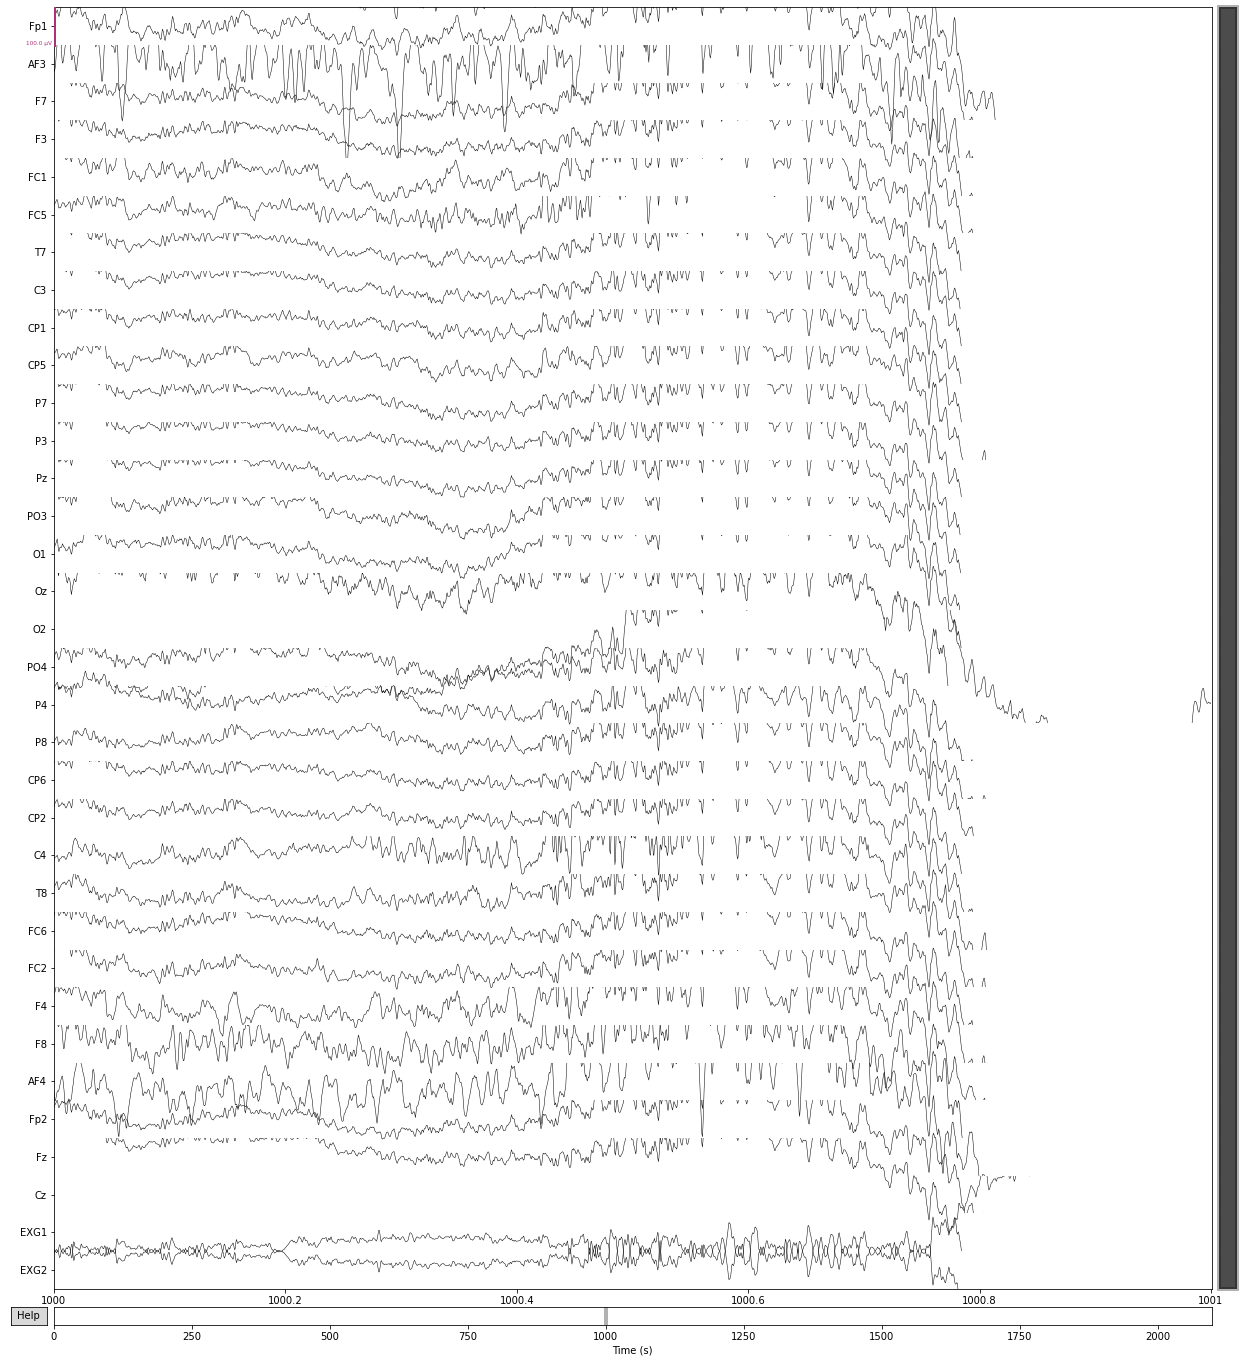

In [6]:
fig = mne.viz.plot_raw(epod_raw_preload[participant_index], events[participant_index], n_channels=50, scalings = 50e-6, duration = 1, start = 1000)


In [7]:
epod_raw_filtered[participant_index].info

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF3, F7, F3, FC1, FC5, T7, C3, CP1, CP5, P7, P3, Pz, PO3, ...
 chs: 34 EEG
 custom_ref_applied: True
 highpass: 0.0 Hz
 lowpass: 417.0 Hz
 meas_date: 2021-06-16 10:34:04 UTC
 nchan: 34
 projs: []
 sfreq: 2048.0 Hz
>

#### Segment EEG into standard and deviant epochs 
+ subtract baseline
+ Reject artefacts
+ Average to get ERPs (for each subject, event, and channel separately))

In [8]:
epochs = mne.Epochs(epod_raw[4], events_12[4], epod.event_dictionary, tmax = 0.8) 

Not setting metadata
2208 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


Loading data for 102 events and 2049 original time points ...
0 bad epochs dropped
Opening epochs-browser...
Loading data for 20 events and 2049 original time points ...


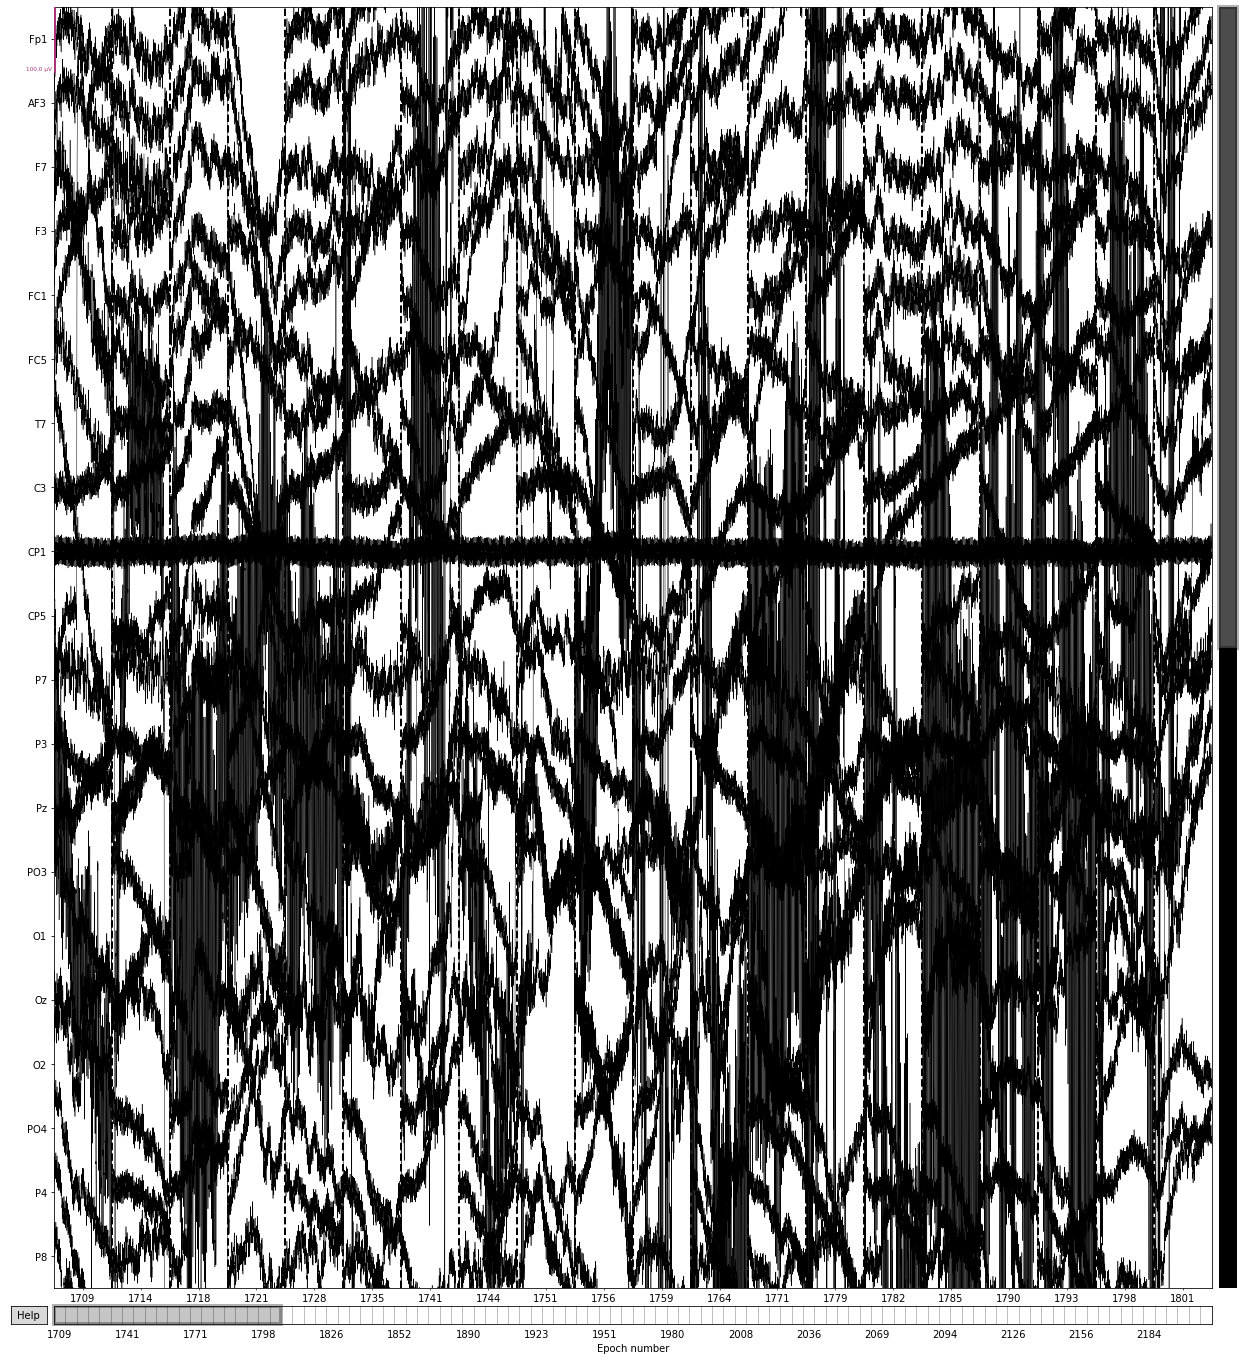

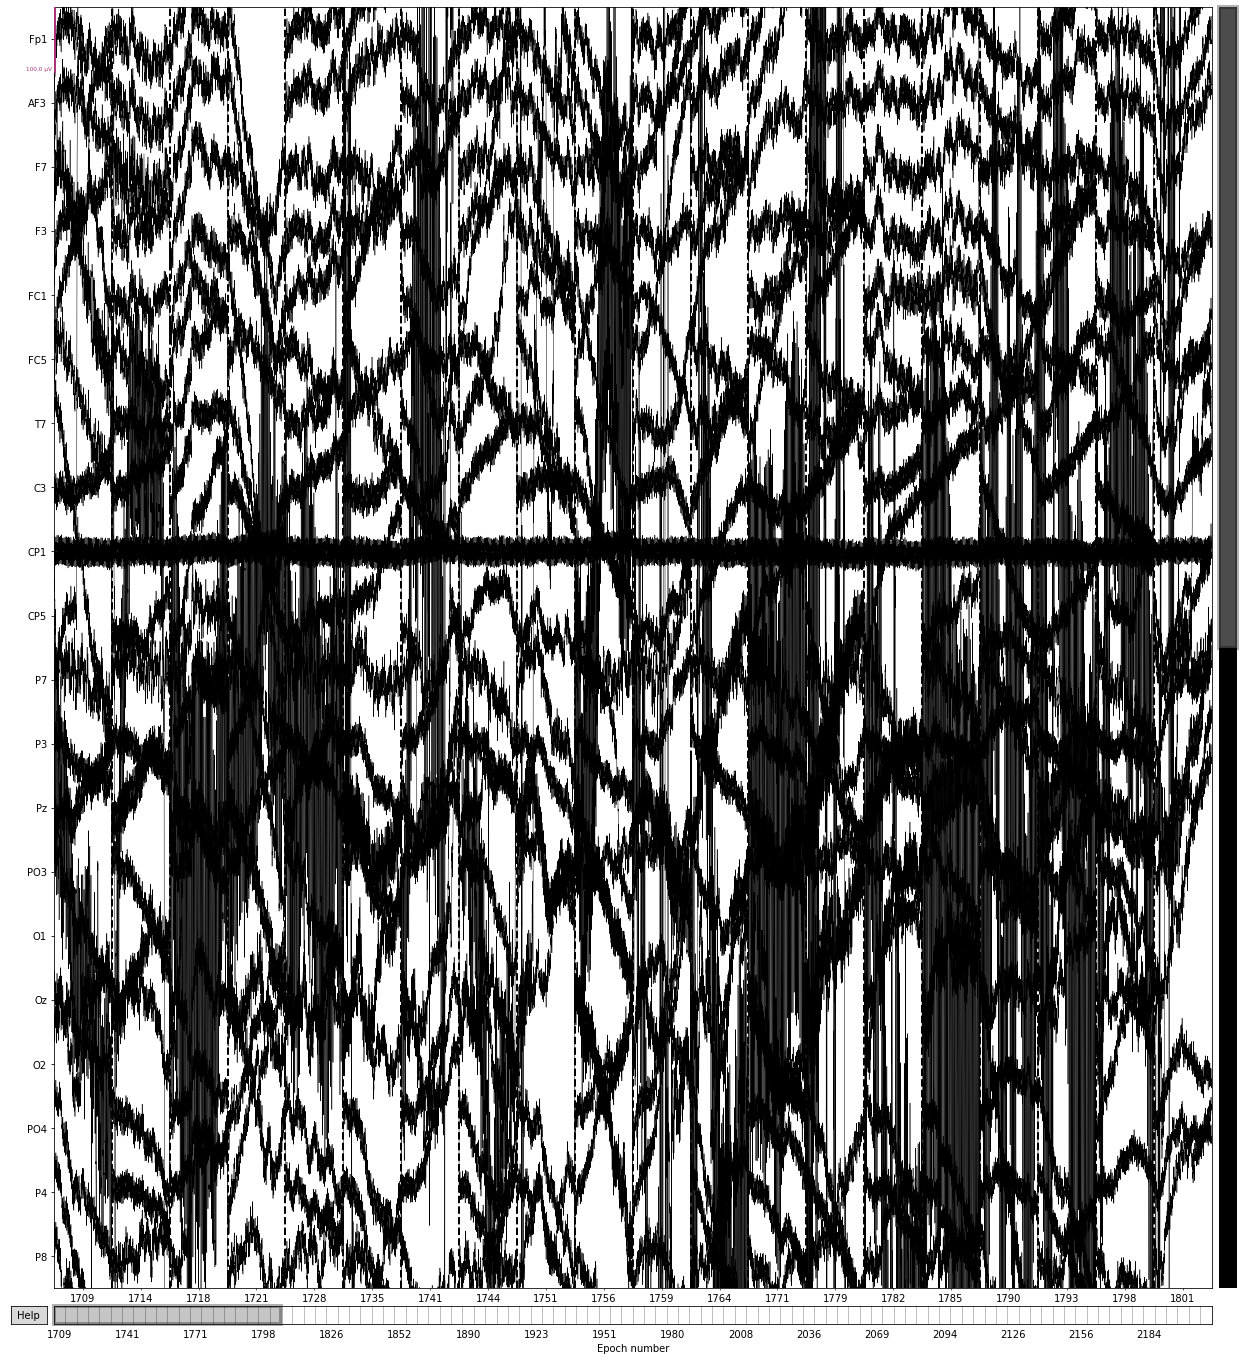

In [9]:
epochs["GopST_D"].plot(scalings = 50e-6)

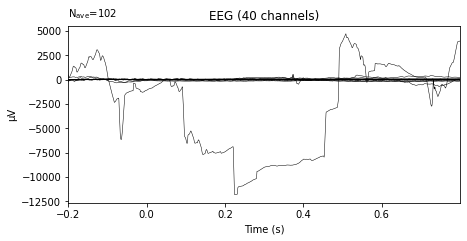

In [10]:
evoked = epochs['GopST_D'].average()
fig = evoked.plot()

In [11]:
epod.event_dictionary

{'GiepMT_FS': 1,
 'GiepMT_S': 2,
 'GiepMT_D': 3,
 'GiepST_FS': 4,
 'GiepST_S': 5,
 'GiepST_D': 6,
 'GopMT_FS': 7,
 'GopMT_S': 8,
 'GopMT_D': 9,
 'GopST_FS': 10,
 'GopST_S': 11,
 'GopST_D': 12}

#### Calculate Mismatch response 
Deviant minus (-) standard 

Check between subjects to see if the subjects have similar responses

Check between channels to observe which parts of the brain are more influenced by the events


#### Extract features 
+ peak latency
+ peak amplitude
+ mean amplitude


#### Create fitting labels
